# NP-likeness analysis

In [1]:
from pathlib import Path

DATA_DIR = Path("../data")
NP_PATH = DATA_DIR / "natural_test.smi"
SYN_PATH = DATA_DIR / "synthetic_test.smi"

assert NP_PATH.exists(), f"Missing file: {NP_PATH}"
assert SYN_PATH.exists(), f"Missing file: {SYN_PATH}"


def read_smi(path: Path) -> list[str]:
    smiles: list[str] = []
    with path.open() as f:
        for line in f:
            s = line.strip().split()[0]
            if s:
                smiles.append(s)
    return smiles


np_smiles = read_smi(NP_PATH)
syn_smiles = read_smi(SYN_PATH)
len(np_smiles), len(syn_smiles)


(69585, 70074)

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

import torch
from src.model import NPLikenessScorer, create_model

# You may change paths if your checkpoints differ
NAT_CKPT = Path("../checkpoints/20250918_2220/gpt2_natural/last.ckpt")
SYN_CKPT = Path("../checkpoints/20250918_2220/gpt2_synthetic/last.ckpt")

assert NAT_CKPT.exists(), f"Missing checkpoint: {NAT_CKPT}"
assert SYN_CKPT.exists(), f"Missing checkpoint: {SYN_CKPT}"

device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_nat = torch.load(NAT_CKPT, map_location=device)
checkpoint_syn = torch.load(SYN_CKPT, map_location=device)

hparams_nat = checkpoint_nat.get("hyper_parameters", {})
hparams_syn = checkpoint_syn.get("hyper_parameters", {})

model_type_nat = "gpt2" if "n_embd" in hparams_nat else "llama"
model_type_syn = "gpt2" if "n_embd" in hparams_syn else "llama"

if model_type_nat == "gpt2":
    model_kwargs_nat = {
        "n_embd": hparams_nat.get("n_embd", 768),
        "n_layer": hparams_nat.get("n_layer", 6),
        "n_head": hparams_nat.get("n_head", 12),
    }
else:
    model_kwargs_nat = {
        "hidden_size": hparams_nat.get("hidden_size", 1024),
        "num_hidden_layers": hparams_nat.get("num_hidden_layers", 8),
        "num_attention_heads": hparams_nat.get("num_attention_heads", 16),
        "intermediate_size": hparams_nat.get("intermediate_size", 2816),
    }

if model_type_syn == "gpt2":
    model_kwargs_syn = {
        "n_embd": hparams_syn.get("n_embd", 768),
        "n_layer": hparams_syn.get("n_layer", 6),
        "n_head": hparams_syn.get("n_head", 12),
    }
else:
    model_kwargs_syn = {
        "hidden_size": hparams_syn.get("hidden_size", 1024),
        "num_hidden_layers": hparams_syn.get("num_hidden_layers", 8),
        "num_attention_heads": hparams_syn.get("num_attention_heads", 16),
        "intermediate_size": hparams_syn.get("intermediate_size", 2816),
    }

model_nat = create_model(
    model_type=model_type_nat,
    learning_rate=hparams_nat.get("learning_rate", 5e-5),
    warmup_steps=hparams_nat.get("warmup_steps", 1000),
    max_length=hparams_nat.get("max_length", 256),
    tokenizer_name=hparams_nat.get(
        "tokenizer_name", "kohbanye/SmilesTokenizer_PubChem_1M"
    ),
    **model_kwargs_nat,
)
model_syn = create_model(
    model_type=model_type_syn,
    learning_rate=hparams_syn.get("learning_rate", 5e-5),
    warmup_steps=hparams_syn.get("warmup_steps", 1000),
    max_length=hparams_syn.get("max_length", 256),
    tokenizer_name=hparams_syn.get(
        "tokenizer_name", "kohbanye/SmilesTokenizer_PubChem_1M"
    ),
    **model_kwargs_syn,
)

model_nat.load_state_dict(checkpoint_nat["state_dict"])
model_syn.load_state_dict(checkpoint_syn["state_dict"])
model_nat.to(device).eval()
model_syn.to(device).eval()

scorer = NPLikenessScorer(model_nat, model_syn)


/home/5/uq02055/fs/git/np-likeness-prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Compute normalized scores
natural_scores_norm = scorer.batch_score_normalized(np_smiles)
synthetic_scores_norm = scorer.batch_score_normalized(syn_smiles)

len(natural_scores_norm), len(synthetic_scores_norm)


Calculating log likelihoods: 100%|██████████| 71/71 [00:18<00:00,  3.77it/s]


(69585, 70074)

In [4]:
# Compute Ertl NP score via RDKit (uses RDKit Contrib NP_Score model)
from pathlib import Path
import pickle
import urllib.request
import importlib.util
import gzip
import shutil
import pandas as pd
from rdkit import Chem

# Ensure npscorer.py and publicnp.model are available
npscorer_py = Path("npscorer.py")
public_model = Path("publicnp.model")
if not npscorer_py.exists():
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/NP_Score/npscorer.py",
        str(npscorer_py),
    )
if not public_model.exists():
    gz_path = Path("publicnp.model.gz")
    if not gz_path.exists():
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/NP_Score/publicnp.model.gz",
            str(gz_path),
        )
    # decompress
    with gzip.open(gz_path, "rb") as f_in, open(public_model, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

# Dynamic import of npscorer with guards
spec = importlib.util.spec_from_file_location("npscorer", str(npscorer_py))
if spec is None or spec.loader is None:
    raise ImportError("Failed to load npscorer module spec")
npscorer = importlib.util.module_from_spec(spec)
spec.loader.exec_module(npscorer)

with open(public_model, "rb") as f:
    fs = pickle.load(f)


def ertl_np_score(smiles: str) -> float | None:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return float(npscorer.scoreMol(mol, fs))
    except Exception:
        return None


# Compute for all evaluation SMILES (order aligned with our df later)
all_smiles_for_ertl = np_smiles + syn_smiles
ertl_scores = [ertl_np_score(s) for s in all_smiles_for_ertl]
ertl_df = pd.DataFrame({"smiles": all_smiles_for_ertl, "ertl_np_score": ertl_scores})
ertl_df.head(3)


,smiles,ertl_np_score
0,CCNC(=O)C=C(C)C=CC=C(C)C=CC1=C(C)C=C(OC)C(C)=C1C,0.942166
1,COC1=CC(C)=C(C=CC(C)=CC=CC(C)=CC(=O)O)C(C)=C1C,1.375890
2,CCOC(=O)C=C(C)C=CC=C(C)C=CC1=C(C)C=C(OC)C(C)=C1C,1.104065


In [5]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

df = pd.DataFrame(
    {
        "smiles": np_smiles + syn_smiles,
        "label": [1] * len(np_smiles) + [0] * len(syn_smiles),
        "score_norm": natural_scores_norm + synthetic_scores_norm,
    }
)

roc_auc = roc_auc_score(df["label"], df["score_norm"])  # ROC-AUC (ours)
ap = average_precision_score(df["label"], df["score_norm"])  # PR-AUC (ours)

roc_auc, ap


(0.9997287727502365, 0.9997358709402292)

In [6]:
# Load NN score CSVs
import pandas as pd
from pathlib import Path

NN_SCORE_NAT = Path(
    "/gs/fs/tga-ohuelab/sakano/git/neural_npfp/data/natural_test_scores.csv"
)
NN_SCORE_SYN = Path(
    "/gs/fs/tga-ohuelab/sakano/git/neural_npfp/data/synthetic_test_scores.csv"
)

assert NN_SCORE_NAT.exists(), f"Missing: {NN_SCORE_NAT}"
assert NN_SCORE_SYN.exists(), f"Missing: {NN_SCORE_SYN}"

nn_score_nat = pd.read_csv(NN_SCORE_NAT)  # columns: smiles,np_score,label
nn_score_syn = pd.read_csv(NN_SCORE_SYN)

# unify to a single series ordered as our df
# left-join by smiles to ensure consistent ordering
nn_score_df = pd.concat([nn_score_nat, nn_score_syn], axis=0, ignore_index=True)
nn_score_df["target"] = (nn_score_df["label"] == "natural").astype(int)

# Align with our df by smiles
merged = df[["smiles", "label"]].merge(
    nn_score_df[["smiles", "np_score", "target"]], on="smiles", how="left"
)

# Drop rows without NN score scores if any
merged = merged.dropna(subset=["np_score"]).reset_index(drop=True)

len(merged), merged.head(3)

(139659,
                                              smiles  label   np_score  target
 0  CCNC(=O)C=C(C)C=CC=C(C)C=CC1=C(C)C=C(OC)C(C)=C1C      1   7.692028       1
 1    COC1=CC(C)=C(C=CC(C)=CC=CC(C)=CC(=O)O)C(C)=C1C      1   7.762484       1
 2  CCOC(=O)C=C(C)C=CC=C(C)C=CC1=C(C)C=C(OC)C(C)=C1C      1  10.048906       1)

Text(0.5, 1.02, 'Joint: NN score vs Ertl')

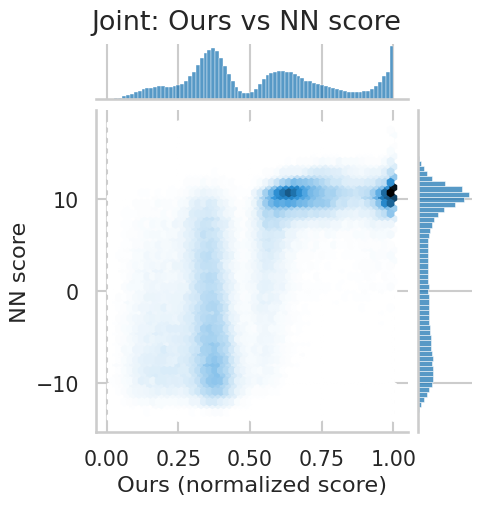

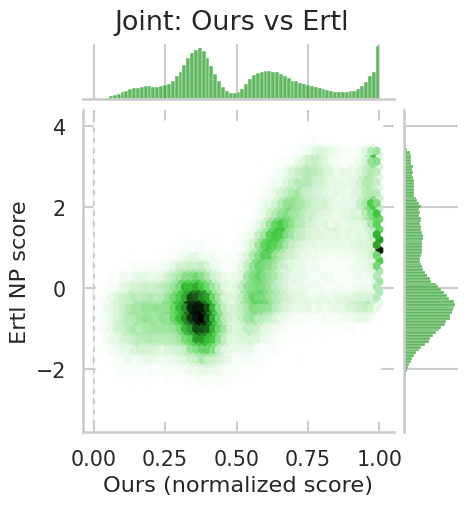

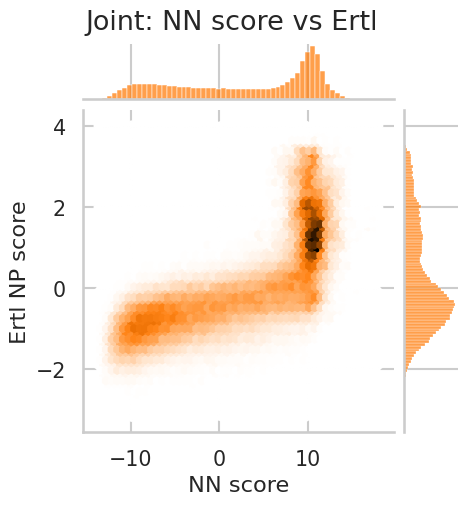

In [7]:
# Joint plots of scores (ours, NN score, Ertl)
import seaborn as sns

# Rebuild alignment if needed and drop rows without Ertl score
sub = df.merge(merged[["smiles", "np_score"]], on="smiles", how="inner")
sub = sub.merge(ertl_df, on="smiles", how="left")
sub_e = sub.dropna(subset=["ertl_np_score"]).copy()

sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")

# Ours vs NN score
g1 = sns.jointplot(
    data=sub_e,
    x="score_norm",
    y="np_score",
    kind="hex",
    height=5,
    color="#1f77b4",
)
g1.set_axis_labels("Ours (normalized score)", "NN score")
g1.figure.suptitle("Joint: Ours vs NN score", y=1.02)

# Ours vs Ertl NP score
g2 = sns.jointplot(
    data=sub_e,
    x="score_norm",
    y="ertl_np_score",
    kind="hex",
    height=5,
    color="#2ca02c",
)
g2.set_axis_labels("Ours (normalized score)", "Ertl NP score")
g2.figure.suptitle("Joint: Ours vs Ertl", y=1.02)

# NN score vs Ertl NP score
g3 = sns.jointplot(
    data=sub_e,
    x="np_score",
    y="ertl_np_score",
    kind="hex",
    height=5,
    color="#ff7f0e",
)
g3.set_axis_labels("NN score", "Ertl NP score")
g3.figure.suptitle("Joint: NN score vs Ertl", y=1.02)

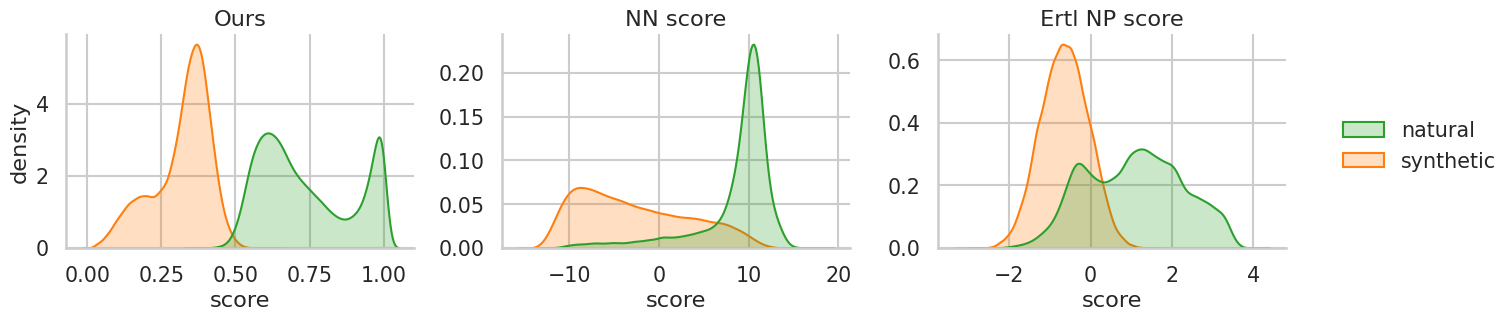

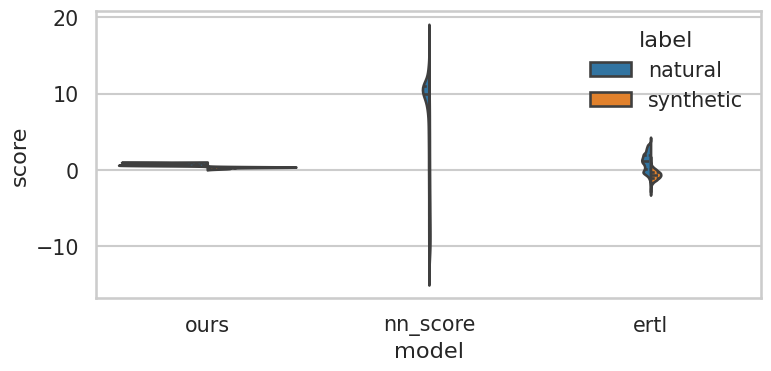

In [8]:
# Separation overview per model: distribution plots and summary metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

# Build aligned frame for all models (recompute to be self-contained)
sub_all = df.merge(merged[["smiles", "np_score"]], on="smiles", how="left")
sub_all = sub_all.merge(ertl_df, on="smiles", how="left")
sub_all["label_name"] = sub_all["label"].map(
    lambda v: "natural" if v == 1 else "synthetic"
)

# Long-form for seaborn (list of DataFrames)
rows = []
for model, col in [
    ("ours", "score_norm"),
    ("nn_score", "np_score"),
    ("ertl", "ertl_np_score"),
]:
    s = sub_all[["label", "label_name", col]].copy()
    s["score"] = s[col]
    s = s.drop(columns=[col])
    s["model"] = model
    s = s.dropna(subset=["score"])  # Ertl can be NaN
    rows.append(s)
long_df = pd.concat(rows, ignore_index=True)

# Summary metrics per model


def ks_statistic(nat: np.ndarray, syn: np.ndarray) -> float:
    if len(nat) == 0 or len(syn) == 0:
        return np.nan
    a = np.sort(nat)
    b = np.sort(syn)
    data = np.sort(np.concatenate([a, b]))
    cdf_a = np.searchsorted(a, data, side="right") / a.size
    cdf_b = np.searchsorted(b, data, side="right") / b.size
    return float(np.max(np.abs(cdf_a - cdf_b)))


summ_rows = []
for model in ["ours", "nn_score", "ertl"]:
    dfm = long_df[long_df["model"] == model]
    y = (dfm["label"].values).astype(int)
    y_score = dfm["score"].values
    # split
    nat = dfm.loc[dfm["label"] == 1, "score"].values
    syn = dfm.loc[dfm["label"] == 0, "score"].values
    # metrics (guard if single-class)
    roc = roc_auc_score(y, y_score) if (y.min() != y.max()) else np.nan
    ap = average_precision_score(y, y_score) if (y.min() != y.max()) else np.nan
    ks = ks_statistic(nat, syn)
    # Cohen's d
    n1, n0 = len(nat), len(syn)
    s1 = np.var(nat, ddof=1) if n1 > 1 else np.nan
    s0 = np.var(syn, ddof=1) if n0 > 1 else np.nan
    if np.isfinite(s1) and np.isfinite(s0) and n1 > 1 and n0 > 1:
        sp = np.sqrt(((n1 - 1) * s1 + (n0 - 1) * s0) / (n1 + n0 - 2))
        d_cohen = (np.mean(nat) - np.mean(syn)) / sp if sp > 0 else np.nan
    else:
        d_cohen = np.nan
    summ_rows.append(
        {
            "model": model,
            "roc_auc": roc,
            "pr_auc": ap,
            "ks": ks,
            "cohen_d": d_cohen,
            "median_nat": np.median(nat) if n1 > 0 else np.nan,
            "median_syn": np.median(syn) if n0 > 0 else np.nan,
            "n": len(dfm),
        }
    )
summary_df = pd.DataFrame(summ_rows)
summary_df

# Distribution overview: KDE per model with label hue
sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")

g = sns.displot(
    data=long_df,
    x="score",
    hue="label_name",
    col="model",
    kind="kde",
    fill=True,
    common_norm=False,
    height=3.5,
    aspect=1.1,
    col_order=["ours", "nn_score", "ertl"],
    facet_kws={"sharex": False, "sharey": False},
    palette={"natural": "tab:green", "synthetic": "tab:orange"},
)
# Move legend outside to avoid overlap
g.figure.subplots_adjust(right=0.8)
if getattr(g, "_legend", None) is not None:
    g._legend.set_bbox_to_anchor((1, 0.5))
    try:
        g._legend.set_loc("center left")
    except Exception:
        pass
    g._legend.set_title("")
g.set_axis_labels("score", "density")
for ax, title in zip(g.axes.flat, ["Ours", "NN score", "Ertl NP score"]):
    ax.set_title(title)
plt.tight_layout()

# Compact summary: violin split by label per model
plt.figure(figsize=(8, 4))
sns.violinplot(
    data=long_df,
    x="model",
    y="score",
    hue="label_name",
    split=True,
    inner="quart",
    order=["ours", "nn_score", "ertl"],
)
plt.xlabel("model")
plt.ylabel("score")
plt.legend(title="label", frameon=False)
plt.tight_layout()

AUCs: ours=0.9997287727502365, nn_score=0.9244099926849519, ertl=0.895200254217957


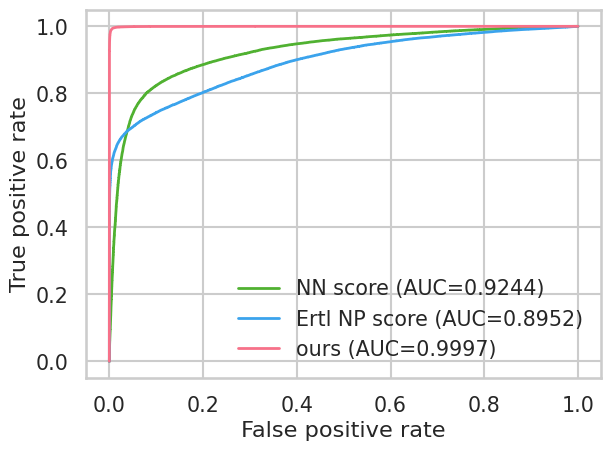

In [9]:
# ROC curve (ours vs NN score vs Ertl NP score)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

palette = sns.color_palette("husl", 3)
color_ours, color_nn_score, color_ertl = palette

# Align by smiles for fair comparison
sub = df.merge(merged[["smiles", "np_score"]], on="smiles", how="inner")
sub = sub.merge(ertl_df, on="smiles", how="left")

y_true = sub["label"].to_numpy()

# ours
y_score_ours = sub["score_norm"].to_numpy()
fpr_o, tpr_o, _ = roc_curve(y_true, y_score_ours)
auc_o = roc_auc_score(y_true, y_score_ours)

# NN score
y_score_nn_score = sub["np_score"].to_numpy()
fpr_n, tpr_n, _ = roc_curve(y_true, y_score_nn_score)
auc_n = roc_auc_score(y_true, y_score_nn_score)

# Ertl NP score (drop NaNs)
mask_e = sub["ertl_np_score"].notna().to_numpy()
fpr_e, tpr_e, _ = roc_curve(y_true[mask_e], sub["ertl_np_score"].to_numpy()[mask_e])
auc_e = roc_auc_score(y_true[mask_e], sub["ertl_np_score"].to_numpy()[mask_e])

plt.plot(fpr_n, tpr_n, label=f"NN score (AUC={auc_n:.4f})", color=color_nn_score, lw=2)
plt.plot(fpr_e, tpr_e, label=f"Ertl NP score (AUC={auc_e:.4f})", color=color_ertl, lw=2)
plt.plot(fpr_o, tpr_o, label=f"ours (AUC={auc_o:.4f})", color=color_ours, lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(frameon=False)
plt.tight_layout()

print(f"AUCs: ours={auc_o}, nn_score={auc_n}, ertl={auc_e}")